In [27]:
import pandas as pd
from snorkel.labeling import labeling_function,PandasLFApplier, LFAnalysis
from snorkel.labeling.model import MajorityLabelVoter, LabelModel

In [28]:
import csv
names = ["qid", 'query', "did", 'url']
df = pd.read_csv("../data/input/orcas_small.tsv", sep='\t', names=names, quoting=csv.QUOTE_NONE)

In [29]:
df.head()

,qid,query,did,url
0,9808497,comcast phone service problems,D1720298,https://www.consumeraffairs.com/cable_tv/comca...
1,7422091,conversions in maths,D1043187,https://www.wyzant.com/resources/lessons/math/...
2,7334168,side effects associated with using elderberry,D1429818,https://www.webmd.com/vitamins-supplements/ing...
3,8991004,what happened to general electric,D119293,https://en.wikipedia.org/wiki/General_Electric
4,7822254,nobel laureates by university,D3485625,http://s.wsj.net/public/resources/documents/st...


In [30]:
df['query'] = df['query'].astype(str)

In [31]:

# Constants for our labels
TRANSACTIONAL = 1
NAVIGATIONAL = 0
ABSTAIN = -1

In [32]:
df_train = df.sample(frac=0.5)
df_test = df[~df.index.isin(df_train.index)]

In [33]:
print(df_train.shape)
print(df_test.shape)
print(df.shape)

(50000, 4)
(50000, 4)
(100000, 4)


In [34]:
@labeling_function()
def lf_login(x):
  keywords = ["login","signin","log in","sign in"]
  return NAVIGATIONAL if any(word in x.query.lower() for word in keywords) else ABSTAIN

In [35]:
@labeling_function()
def lf_download_lookup(x):
  keywords = ["download", "obtain"]
  return TRANSACTIONAL if any(word in x.query.lower() for word in keywords) else ABSTAIN

In [36]:
@labeling_function()
def lf_audio_video_lookup(x):
  keywords = ["audio", "video", "image", "images"]
  return TRANSACTIONAL if any(word in x.query.lower() for word in keywords) else ABSTAIN

In [37]:
@labeling_function()
def lf_extension_lookup(x):
  keywords = ["jpeg", "rar", "png", "mp3"]
  return TRANSACTIONAL if any(word in x.query.lower() for word in keywords) else ABSTAIN

In [38]:
@labeling_function()
def lf_transaction_lookup(x):
  keywords = ["online", "free", "transaction", "buy"]
  return TRANSACTIONAL if any(word in x.query.lower() for word in keywords) else ABSTAIN

In [39]:
@labeling_function()
def lf_www(x):
  keywords = ["www", "http", "https"]
  return NAVIGATIONAL if any(word in x.query.lower() for word in keywords) else ABSTAIN

In [40]:
### Apply Fxn
lfs = [lf_login,lf_download_lookup, lf_audio_video_lookup, lf_extension_lookup, lf_transaction_lookup, lf_www]
applier = PandasLFApplier(lfs=lfs)
L_train = applier.apply(df=df)

100%|█████████████████████████████████| 100000/100000 [00:13<00:00, 7652.96it/s]


In [41]:
L_train

array([[-1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1],
       ...,
       [-1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1]])

In [42]:
LFAnalysis(L=L_train,lfs=lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
lf_login,0,[0],0.01279,0.00131,0.00045
lf_download_lookup,1,[1],0.00602,0.00140,0.00014
lf_audio_video_lookup,2,[1],0.00227,0.00032,0.00000
lf_extension_lookup,3,[1],0.00225,0.00021,0.00005
lf_transaction_lookup,4,[1],0.02443,0.00241,0.00094
lf_www,5,[0],0.01834,0.00155,0.00069


In [43]:
LFAnalysis(L=L_train,lfs=lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
lf_login,0,[0],0.01279,0.00131,0.00045
lf_download_lookup,1,[1],0.00602,0.00140,0.00014
lf_audio_video_lookup,2,[1],0.00227,0.00032,0.00000
lf_extension_lookup,3,[1],0.00225,0.00021,0.00005
lf_transaction_lookup,4,[1],0.02443,0.00241,0.00094
lf_www,5,[0],0.01834,0.00155,0.00069


In [44]:
# Build the model
label_model = LabelModel(cardinality=2,verbose=True)
label_model.fit(L_train=L_train,n_epochs=500,log_freq=100,seed=123)


In [45]:

df['Labels'] = label_model.predict(L=L_train,tie_break_policy="abstain")

In [46]:
df["Labels"].value_counts()

-1    93755
 1     3241
 0     3004
Name: Labels, dtype: int64

In [47]:
df[df.Labels == TRANSACTIONAL]


,qid,query,did,url,Labels
36,10588333,united airlines check in online boarding pass,D22221,https://www.united.com/ual/en/us/,1
103,11094590,bestbuy rewards,D2798010,http://forums.bestbuy.com/t5/Customer-Service-...,1
111,5998697,file my unemployment claim online,D156425,https://esd.wa.gov/unemployment,1
117,2506359,blue eyes song download,D2072509,http://www.lyricsmint.com/2013/11/blue-eyes-ho...,1
135,12345415,aa account online,D2485840,http://www.theaa.com/myaa/frequently-asked-que...,1
...,...,...,...,...,...
99845,9631046,series top online,D1564168,https://www.rottentomatoes.com/top-tv/,1
99888,3865125,google chrome downloader,D554717,https://chrome-64-bit.en.softonic.com/,1
99913,10777534,.net framework 4.7 download,D2878205,https://blogs.msdn.microsoft.com/dotnet/2017/0...,1
99914,3750564,halogen-free,D233868,https://en.wikipedia.org/wiki/Halogen,1


In [50]:
df[df.Labels == NAVIGATIONAL]

,qid,query,did,url,Labels
68,8535833,google apps account sign in,D2846230,https://myaccount.google.com/intro/security,0
114,8340312,www.home.fedex.com/corp,D746398,https://www.fedex.com/en-us/home.html,0
122,6388359,www.hip2,D2084981,http://hip2save.com/,0
130,10862166,wep login,D229037,https://www.lifewire.com/what-is-a-wep-key-818305,0
149,9813398,gdc email login,D1396177,https://georgia.gov/agencies/georgia-departmen...,0
...,...,...,...,...,...
99819,4925149,hhh exchange login,D3080248,https://hhaexchange.com/,0
99915,10932107,) https://jkodirect.jten.mil,D3283699,https://jkodirect.jten.mil/,0
99916,5416904,roblox login hack,D153050,http://bugmenot.com/view/roblox.net,0
99917,11444963,www.pacareelink.pa.gov,D618717,https://www.jobgateway.pa.gov/jponline/JobSeek...,0


In [51]:
import seaborn as sns

<AxesSubplot:xlabel='Labels', ylabel='count'>

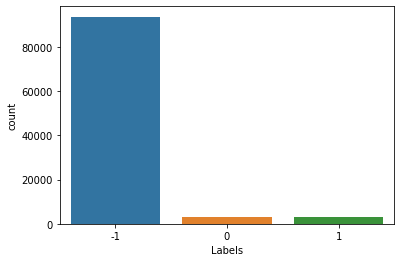

In [52]:
sns.countplot(x='Labels',data=df)